# Running Differential Gene Expression Analyses on RNA-sequencing datasets... On Google Colab!
Welcome! This notebook's purpose is to serve as a one-stop-shop to run some standard Differential Gene Expression Analyses (DGEA) using DESeq2 and edgeR **without downloading anything**! 

The intuition behind how this works is as follows:

1. The code in this notebook runs on Google's servers. Each time you launch this notebook, all the software you need to run it is installed **on Google's servers**.

2. To modify the parameters of the DGEA, you just need to the lines in this cell.

3. To run the analysis, just click on Runtime / Run All.



In [0]:
%load_ext rpy2.ipython
# https://stackoverflow.com/questions/54595285/how-to-use-r-with-google-colaboratory

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


This cell loads the pre-written DGEA code.

In [0]:
%%R
source("/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/R_code/all_code.R")

***This is the cell that contains the DGEA's parameters.***

***It is the only cell which you should need to change.***

In [0]:
%%R
counts.matrix.filepath <- "/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/primary_analysis/QIAseqUltraplexRNA_90846_relabelled_alphaordered.csv"

keep_columns <- c(
  #"EtOH_RepA",  
  #"NT_RepA",
  #"NT_RepB",
  #"NT_RepC",
  #"RA_RepA",
  "RA_RepB",
  "RA_RepC",
  "siGFP_RepA",
  "siGFP_RepB",
  "siGFP_RepC",
  "siM1_RepA",
  "siM1_RepB",
  "siM1_RepC",
  "siNC_RepA",
  "siNC_RepB",
  "siNC_RepC"
)

fdr <- 0.1

# This section contains parameters used when plotting the rejection curves obtained by repeating DESeq2's independent filtering method with a variety of user-defined filtering criteria (filtering functions)
quantiles <- seq(from=0.1, to=0.95, by=0.01)

*Load the read count matrix, and visualize each sample's read count distribution*

[1] "Loading raw counts matrix"
                         gene strand chrom loc.5. loc.3. EtOH_RepA NT_RepA
ENSG00000278267.1   MIR6859-1     -1  chr1  17436  17369         9       6
ENSG00000243485.5 MIR1302-2HG      1  chr1  29554  31109         0       1
ENSG00000227232.5      WASH7P     -1  chr1  29570  14404         6       6
ENSG00000284332.1   MIR1302-2      1  chr1  30366  30503         0       0
ENSG00000268020.3      OR4G4P      1  chr1  52473  53312         0       0
ENSG00000279457.4  FO538757.1     -1  chr1 195411 185217         1       2
                  NT_RepB NT_RepC RA_RepA RA_RepB RA_RepC siGFP_RepA siGFP_RepB
ENSG00000278267.1       0       4       1       5       5          4          6
ENSG00000243485.5       0       0       3       1       0          2          0
ENSG00000227232.5       1       3       8       4       6          6          6
ENSG00000284332.1       0       0       0       0       0          1          0
ENSG00000268020.3       0       0       0  

R[write to console]: No id variables; using all as measure variables



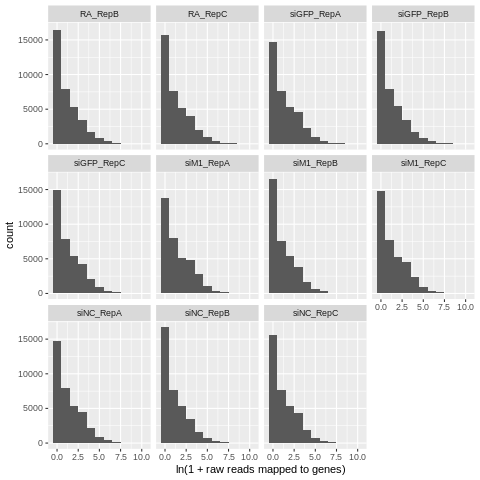

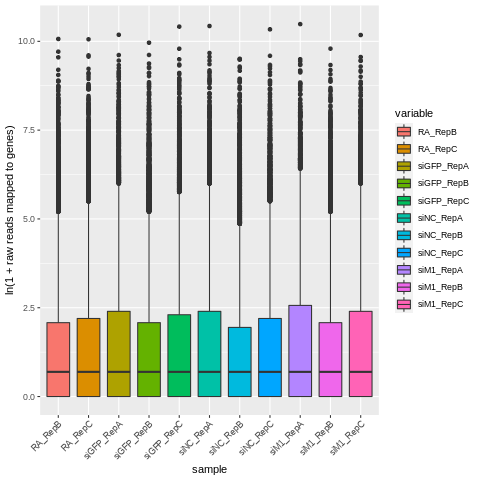

In [0]:
%%R
raw.counts.data <- rawCountsMatrix_to_dataframe(
  counts.matrix.filepath,
  keep_columns=keep_columns,
  make_histogram=TRUE, make_boxplot=TRUE,
  make_ensembl_to_symbol = FALSE,
  sep = ',',
  verbose=TRUE
)

sample.data <- data.frame(
  condition=raw.counts.data$conditions,
  row.names=colnames(raw.counts.data$raw.data)
)

colnames(sample.data) <- c("condition")

contrasts <- design.pairs(unique(sample.data$condition))

## DGEA with DESeq2
### This cell takes care of formatting our raw read count matrix into the format that DESeq2 expects

In [0]:
%%R
dds <- DESeqDataSetFromMatrix(
  countData = raw.counts.data$raw.data,
  colData = sample.data,
  design = ~ condition
)


### This cell plots the correlation matrix between samples (after the data has been normalized using DESeq2's normalization).

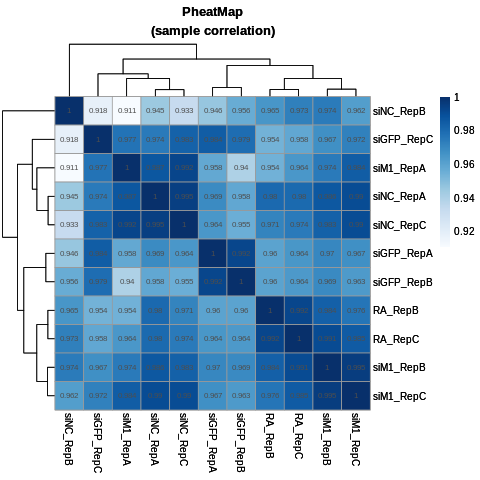

In [0]:
%%R
plotPheatMap(dds, fromtool="deseq")

### Here we display Scree and PC1-vs-PC2 plots to compare samples after their read counts have been normalized with DESeq2

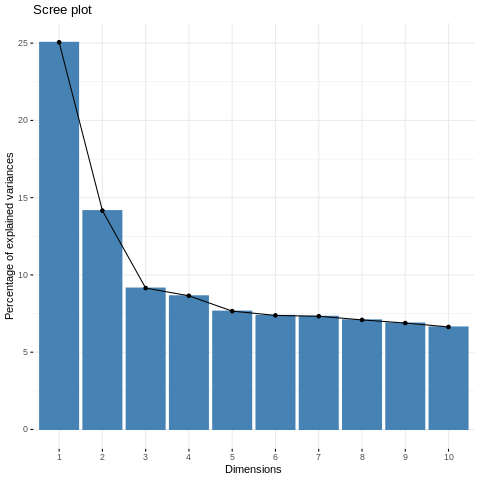

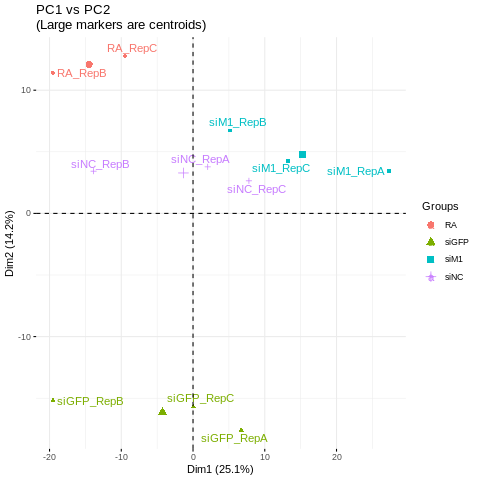

In [0]:
%%R
rld <- rlog(dds, blind=TRUE)
prcomp.output <- prcomp(t(assay(rld)))
plotScree(prcomp.output)
plotPC1vsPC2(prcomp.output, dds)

### Finally, we run DGEA with DESeq2, and plot the rejection curves obtained through DESeq2's independent filtering method



R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



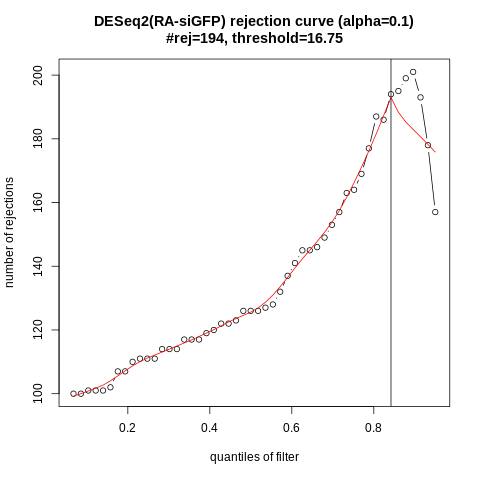

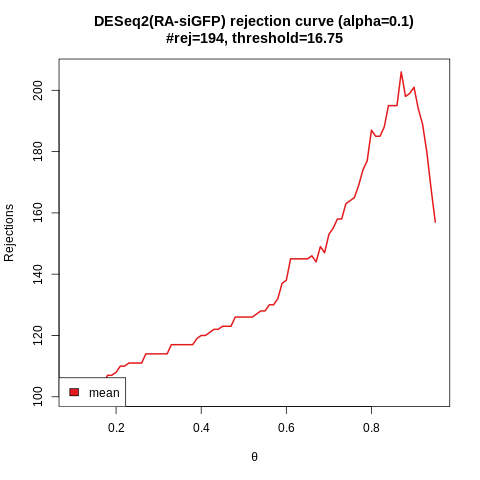

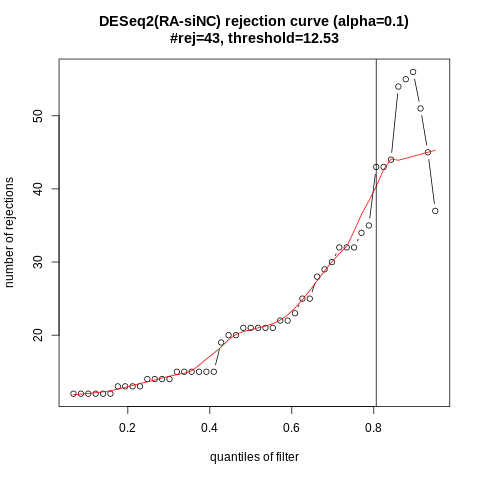

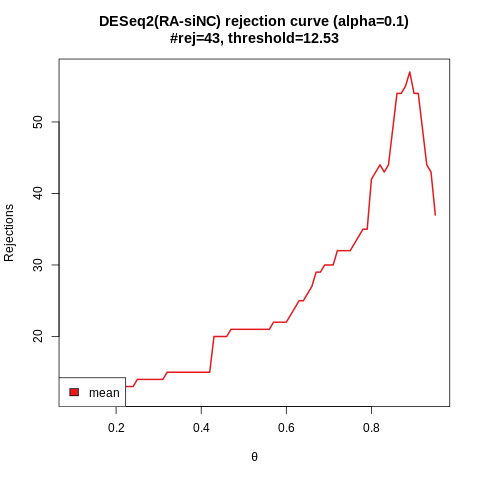

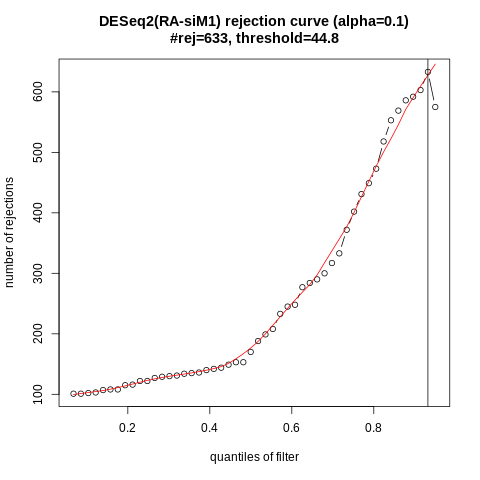

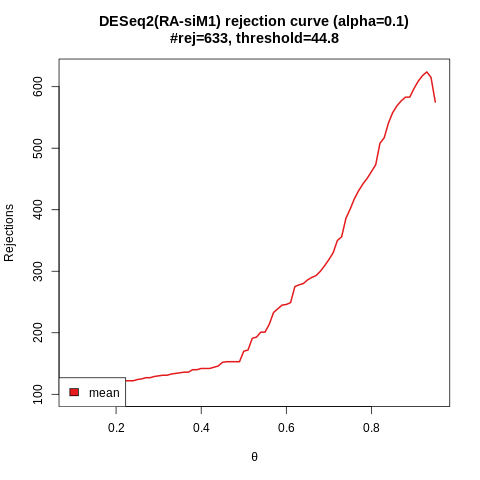

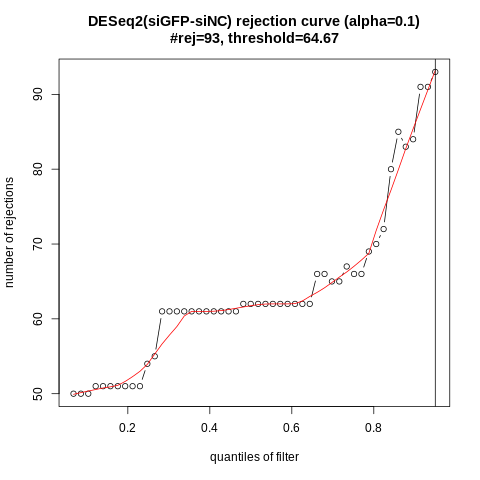

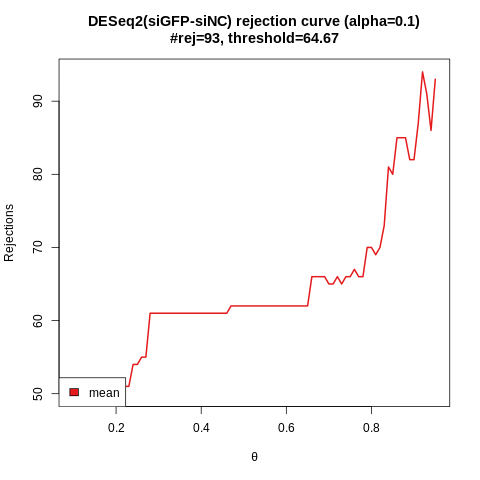

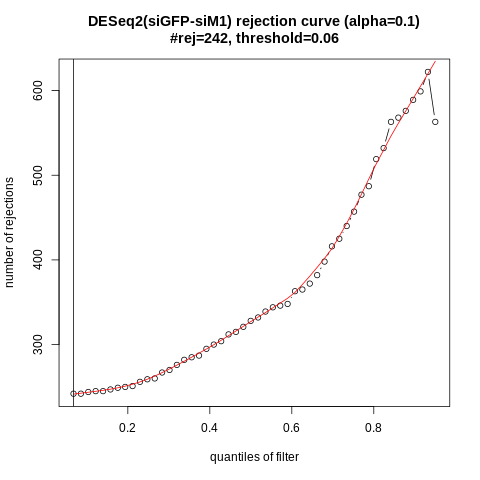

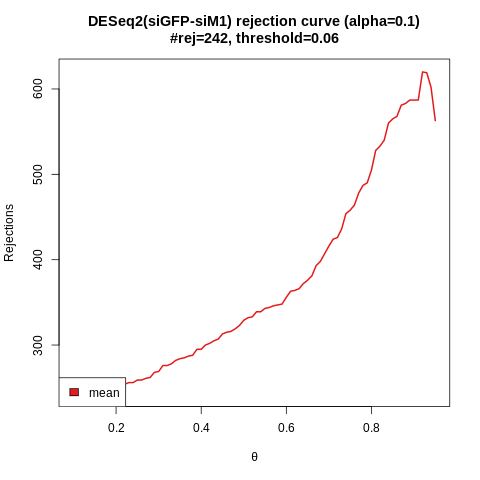

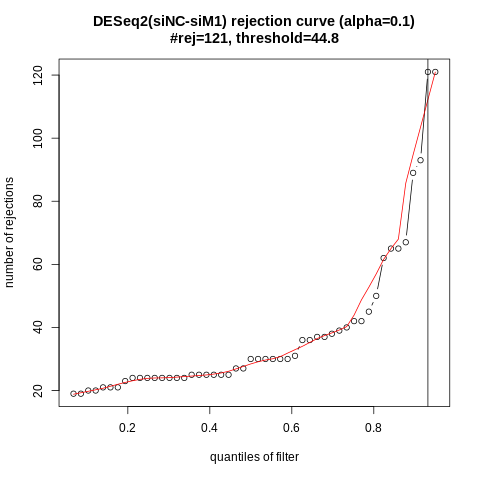

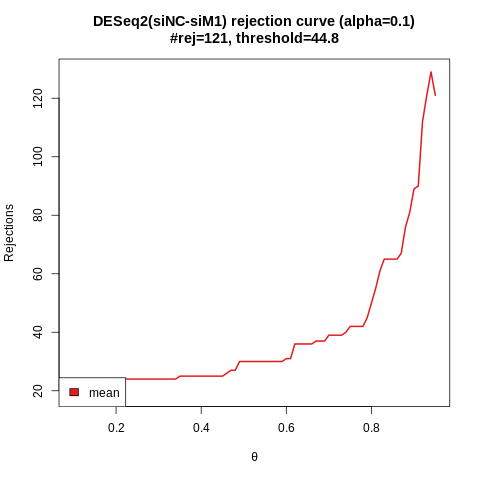

In [0]:
%%R
DESeq2.results <- DESeq2_DGE_analysis( 
    dds, 
    fdr, 
    contrasts, 
    quantiles=quantiles, 
    verbose = FALSE, 
    chosen_filter="mean"
  )

### Now visualize the Scree and PC1-vs-PC2 plots obtained from the data that has been normalized and "filtered" by DESeq2 and its independent filtering method

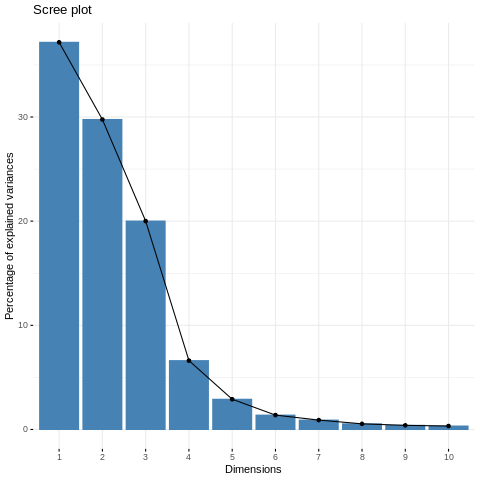

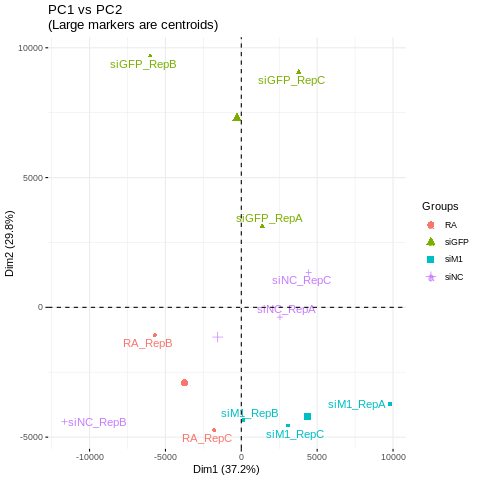

In [0]:
%%R
DESeq2.normalized.data <- as.data.frame(counts(DESeq2.results$DGE_obj, normalized=TRUE))
prcomp.output <- prcomp(t(DESeq2.normalized.data))
plotScree(prcomp.output)
plotPC1vsPC2(prcomp.output, dds)

## DGEA with edgeR
### This cell takes care of formatting our raw read count matrix into the format that edgeR expects

In [0]:
%%R
dge_obj <- DGEList(
  counts=raw.counts.data$raw.data,
  group=raw.counts.data$conditions
)
design <- model.matrix(~0+sample.data$condition)
rownames(design) <- row.names(sample.data)
colnames(design) <- gsub("sample.data.condition","",colnames(design))

### We now run DGEA with edgeR, and plot the rejection curves obtained with independent filtering method



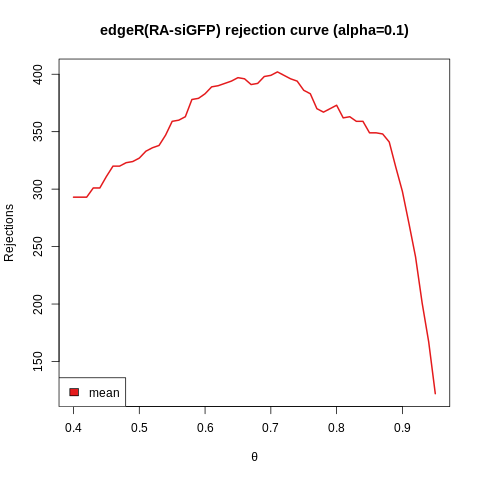

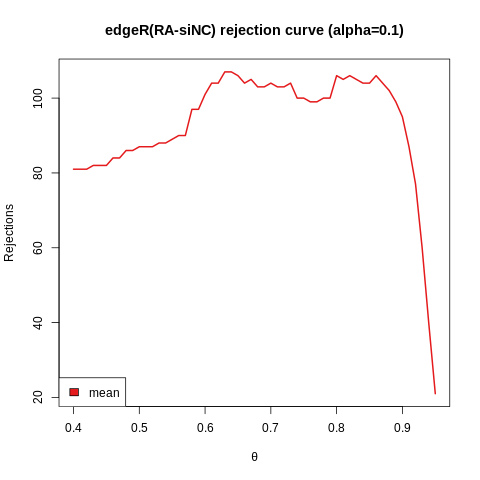

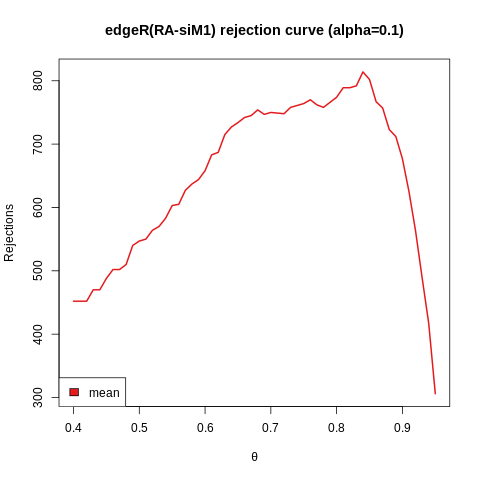

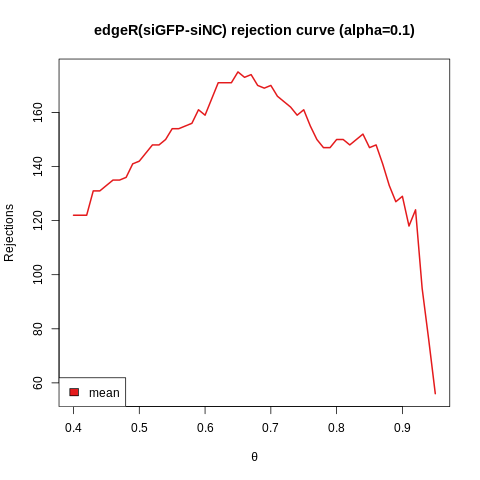

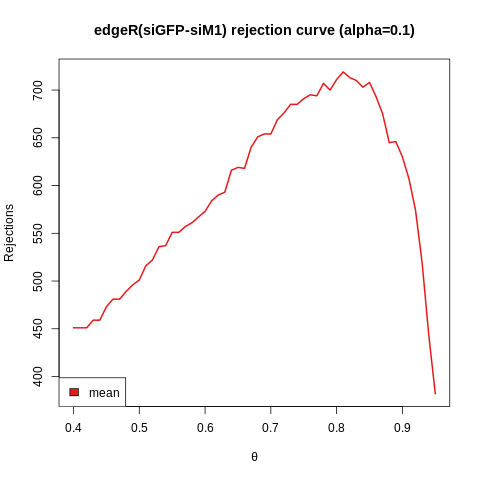

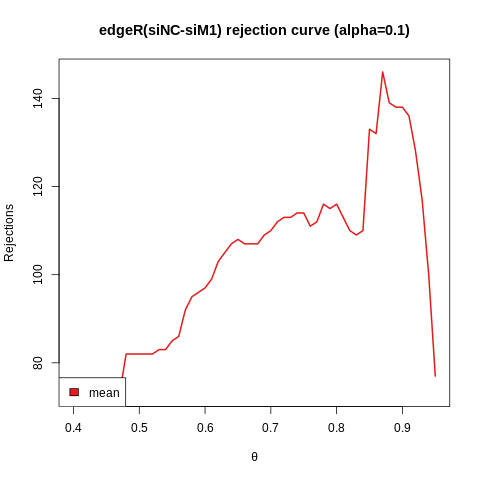

In [0]:
%%R
edgeR.results <- edgeR_DGE_analysis(
    dge_obj, 
    design, 
    fdr, 
    contrasts = contrasts, 
    verbose=FALSE, 
    chosen_filter="mean"
)

### Once again, we visualize the Scree and PC1-vs-PC2 plots obtained from the data that has been normalized and "filtered" by edgeR and independent filtering

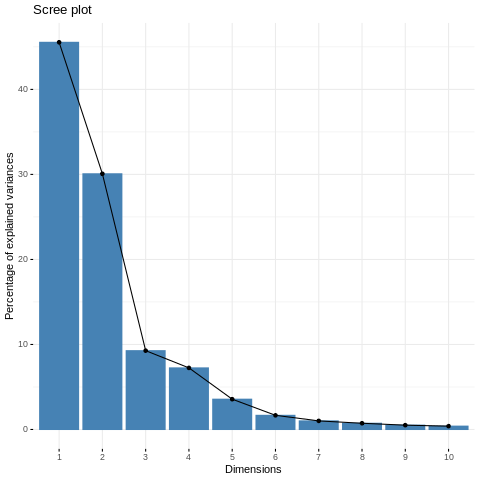

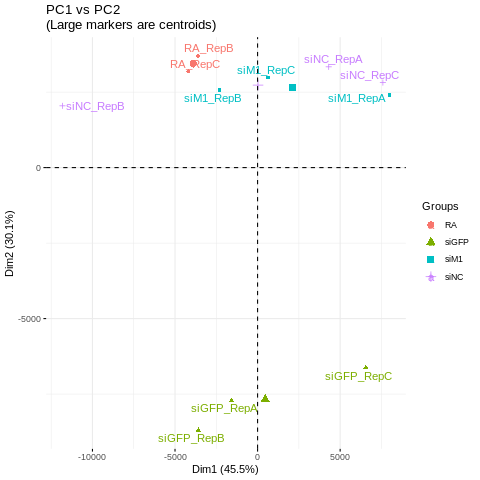

In [0]:
%%R
prcomp.output <- prcomp(t(
   t(t(edgeR.results$DGE_obj$pseudo.counts)*(edgeR.results$DGE_obj$samples$norm.factors))
))
plotScree(prcomp.output)
plotPC1vsPC2(prcomp.output, dds)

## Now we save the results of our DGEA on your Google Drive (for bookkeeping and for downstream analyses)

### First we want to find the gene symbol that corresponds to each Ensembl ID (since those are the gene identifiers we've been using so far). So the first step is to get that map from Ensembl.

In [0]:
%%R
symbol.to.id.map <- get.conversion.map(raw.counts.data)

R[write to console]: Map loaded!



In [0]:
%%R
head(symbol.to.id.map)

R[write to console]: Error in head(symbol.to.id.map) : object 'symbol.to.id.map' not found
Calls: <Anonymous> -> <Anonymous> -> <Anonymous> -> withVisible -> head




Error in head(symbol.to.id.map) : object 'symbol.to.id.map' not found
Calls: <Anonymous> -> <Anonymous> -> <Anonymous> -> withVisible -> head


### Finally, we save our DGEA results in a tab-separated file.

In [0]:
%%R
spreadsheet_dir_path <- save.spreadsheet( 
  DESeq2.results, 
  edgeR.results, 
  raw.counts.data, 
  contrasts, 
  symbol.to.id.map, fdr,
  "All_RAi_except_RAsA", 
  "/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis", 
  "All_RAi_except_RAsA",
  saveoutput=TRUE
)

[1] "RA"    "siGFP"
[1] "Saving in: /content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA/DGEA_results_All_RAi_except_RAsA_RA-siGFP_fdr_0.1.tsv"
[1] "saved results for RA-siGFP in:/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA/DGEA_results_All_RAi_except_RAsA_RA-siGFP_fdr_0.1.tsv"
[1] "RA"   "siNC"
[1] "Saving in: /content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA/DGEA_results_All_RAi_except_RAsA_RA-siNC_fdr_0.1.tsv"
[1] "saved results for RA-siNC in:/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA/DGEA_results_All_RAi_except_RAsA_RA-siNC_fdr_0.1.tsv"
[1] "RA"   "siM1"
[1] "Saving in: /content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA/DGEA_results_All_RAi_except_RAsA_RA-siM1_fdr_0.1.tsv"
[1] "saved results for RA-siM1 in:/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondar

In [0]:
%%R
#spreadsheet_dir_path <- file.path("/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis", "All_RAi_except_RAsA")
print(spreadsheet_dir_path)

[1] "/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA"


In [0]:
# Additional pathway analysis stuff would go here

In [0]:
import rpy2

## Post-DGEA visualizations

In [0]:
# standard library dependencies
import os
import re 
from typing import Tuple, Mapping, List, Union

# external dependencies; already installed in Google colab environment
import pandas as pd 


try:
  import matplotlib.pyplot as plt 
except ModuleNotFoundError:
  print("Installing maptlotlib with pip...")
  !pip install matplotlib
  import matplotlib.pyplot as plt 

try:
  from supervenn import supervenn
except ModuleNotFoundError:
  print("Installing supervenn with pip...")
  !pip install supervenn
  from supervenn import supervenn

def load_files_from_dir(dirpath:str, **read_csv_kwargs) -> Mapping[str, pd.DataFrame]:
    """
    """
    assert os.path.isdir(dirpath)
    files = os.listdir(dirpath)
    
    try:
        assert files != []
    except AssertionError as ae:
        message = "\n".join([
            "Could not find any files in: ",
            dirpath
        ])
        raise FileNotFoundError(message) from ae 

    read_csv_args = {
        "sep":'\t',
        "index_col":None
    }

    read_csv_args.update(read_csv_kwargs)

    dataframes_dictionary = {
        filename: pd.read_csv(
            os.path.join(dirpath, filename), 
            **read_csv_args
        )
        for filename in files
    }

    return dataframes_dictionary

def compare_with_max_adjp(  dataframes_dictionary:Mapping[str,  pd.DataFrame],
                            max_adjp:Union[List[float], float]):
    """
    """
    if isinstance(max_adjp, float):
        max_adjp = [max_adjp]
    for alpha in max_adjp:
        all_filenames = list(dataframes_dictionary.keys())
        common_prefix = os.path.commonprefix(all_filenames)
        for filename, df in dataframes_dictionary.items():
            comparison = filename.replace(common_prefix,'')
            supervenn_args = []

            for result_columns, tool in zip(["padj", "edgeR.exactTest_FDR"], ["DESeq2", "edgeR"]):
                degset = df.loc[df[result_columns] <= alpha, "Ensembl ID"]
                degset = set(degset.values.tolist())
                supervenn_args.append(
                    (f"{comparison} with {tool} @ FDR={alpha}", degset)
                )
            x = supervenn(
                [set_ for (name, set_) in supervenn_args ],
                set_annotations=[ name for (name, set_) in supervenn_args ]
            )
            plt.show()

In [0]:
df_dict = load_files_from_dir(
    #"/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA"
    str(rpy2.robjects.r['spreadsheet_dir_path'])[5:-2]
)

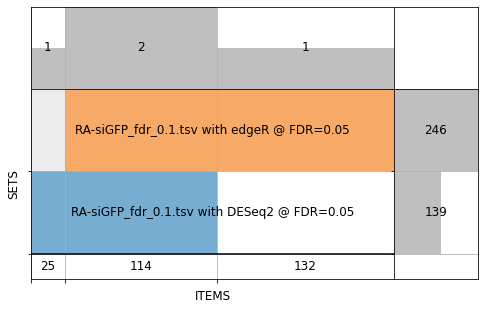

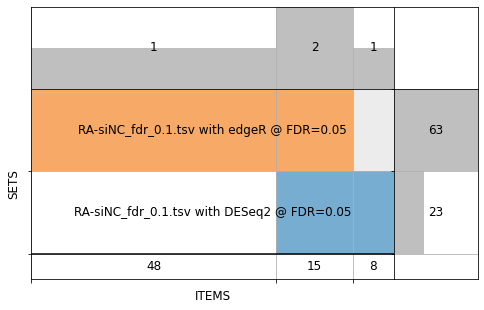

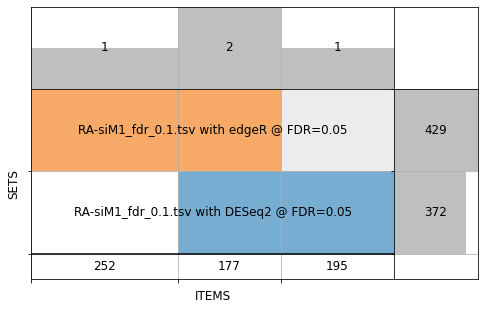

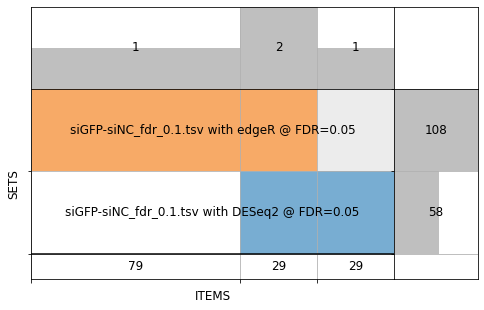

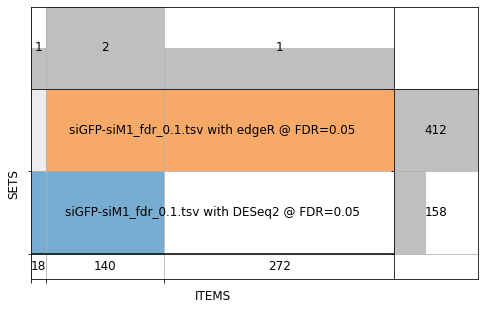

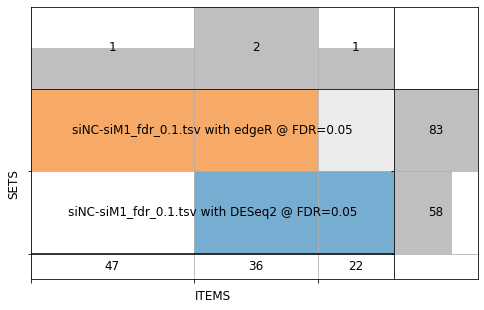

In [83]:
compare_with_max_adjp(df_dict, [0.05])

/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA
/content/drive/My Drive/msc-lncrna-project/jd-rnaseq/secondary_analysis/All_RAi_except_RAsA
